## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
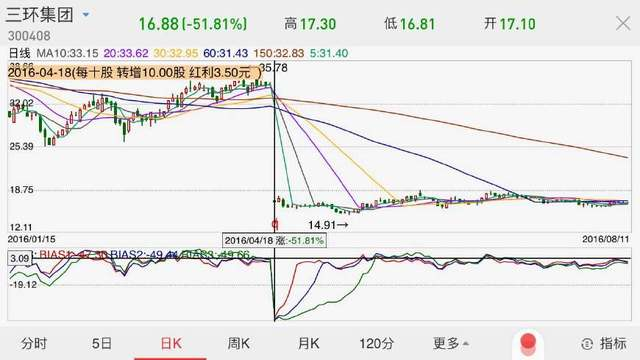

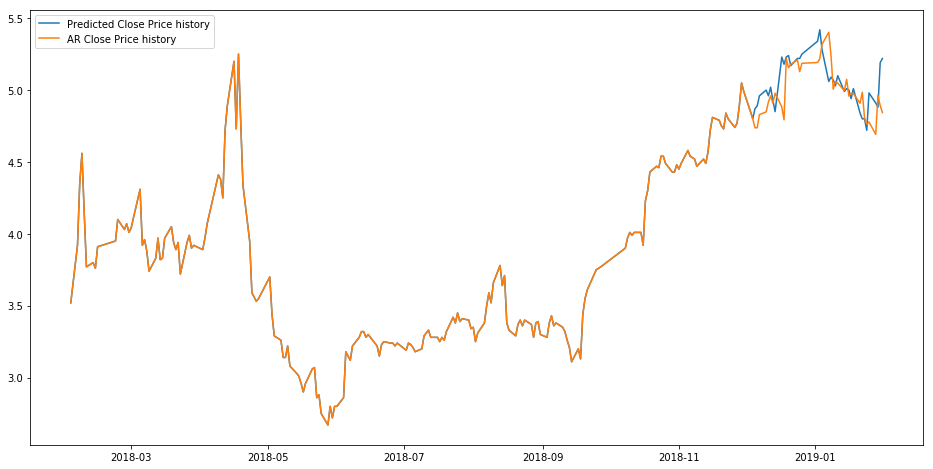

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [2]:
import unicodedata
import string

#26字母
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


In [3]:
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    #获取文件名
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
n_categories

18

In [5]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [5]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [6]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

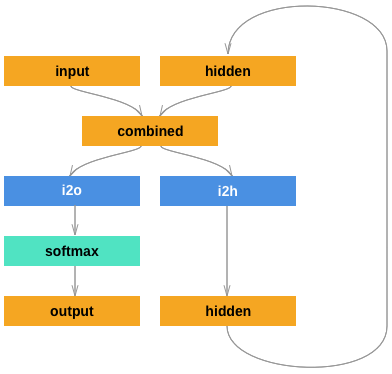

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)#按照纬度2，按照行softmax

    def forward(self, input, hidden):
        #按维数1（列）拼接
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [8]:
#n_letters = 57
#n_hidden = 128
#n_categories = 18
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
print(rnn.initHidden())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])


### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [10]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [11]:
output

tensor([[-2.9504, -2.8828, -2.8662, -2.8913, -2.7927, -2.8948, -2.9255, -2.9571,
         -2.9663, -2.8048, -2.9732, -2.8740, -2.9575, -2.9567, -2.9910, -2.7559,
         -2.8473, -2.7847]], grad_fn=<LogSoftmaxBackward>)

In [12]:
next_hidden

tensor([[ 0.0370,  0.1069,  0.1033,  0.0409, -0.0219, -0.0800, -0.0698, -0.0052,
          0.0540,  0.0827, -0.0239, -0.0100, -0.0443, -0.0775,  0.0498,  0.0085,
         -0.0412,  0.1353,  0.0321, -0.0787,  0.0129, -0.0086,  0.0374,  0.0046,
         -0.0133, -0.0260, -0.0540,  0.0745,  0.0042, -0.0023, -0.0304,  0.0422,
         -0.0200, -0.0270, -0.1235,  0.0512, -0.0413, -0.0101, -0.0149, -0.0733,
         -0.0452,  0.0299,  0.0356,  0.0257,  0.0658,  0.0042,  0.0353,  0.0588,
          0.0092, -0.0121, -0.0492,  0.0834,  0.0351, -0.0475, -0.0752,  0.0862,
          0.0442,  0.0449,  0.0710,  0.1330,  0.0623, -0.0763,  0.0332, -0.0542,
          0.0577,  0.0810, -0.0155, -0.0404,  0.0203, -0.0549, -0.0026, -0.0464,
         -0.0677,  0.0342, -0.0740,  0.0553,  0.0767, -0.0668, -0.0500, -0.0365,
         -0.0438, -0.0673,  0.0230,  0.1199, -0.0325,  0.0473,  0.0409, -0.0182,
          0.0471, -0.0136, -0.0345,  0.0476, -0.0128,  0.0049,  0.0344, -0.0118,
          0.0741,  0.0783,  

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [13]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9504, -2.8828, -2.8662, -2.8913, -2.7927, -2.8948, -2.9255, -2.9571,
         -2.9663, -2.8048, -2.9732, -2.8740, -2.9575, -2.9567, -2.9910, -2.7559,
         -2.8473, -2.7847]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [7]:
#把结果转化为名称
def category_from_output(output):
    top_n, top_i = output.topk(1)
    #print(top_n)#最大值
    #print(top_i)#最大值索引
    category_i = top_i[0].item()
    #print(category_i)#索引
    return all_categories[category_i], category_i

对于刚刚产生的output，我们使用这个函数

In [16]:
print(category_from_output(output))

('French', 5)


### 1.8 随机生成训练数据

In [8]:
import random

#随机取0到(l-1)一个数
def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    #随机取列表
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)
    print(category_tensor)
    print(line_tensor.size())

category = Korean / line = Lim 
tensor([11])
torch.Size([4, 1, 57])
category = Spanish / line = Antunez
tensor([16])
torch.Size([7, 1, 57])
category = Greek / line = Makricosta
tensor([7])
torch.Size([10, 1, 57])
category = Czech / line = Komo
tensor([2])
torch.Size([4, 1, 57])
category = French / line = Desrosiers
tensor([5])
torch.Size([10, 1, 57])
category = Italian / line = Agostini
tensor([9])
torch.Size([8, 1, 57])
category = Japanese / line = Hamaguchi
tensor([10])
torch.Size([9, 1, 57])
category = English / line = Bickley
tensor([4])
torch.Size([7, 1, 57])
category = Italian / line = Baldovini
tensor([9])
torch.Size([9, 1, 57])
category = Italian / line = Pittaluga
tensor([9])
torch.Size([9, 1, 57])


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [18]:
criterion = nn.CrossEntropyLoss()

In [9]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    #每次迭代后梯度清零
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [20]:
import time
import math

n_iters = 5000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 10% (0m 2s) 2.8815 Urbanovska / French ✗ (Czech)
1000 20% (0m 4s) 2.7578 Porosenkov / Russian ✓
1500 30% (0m 5s) 2.8859 Krytinar / Arabic ✗ (Czech)
2000 40% (0m 7s) 2.7738 Xuan / Irish ✗ (Chinese)
2500 50% (0m 10s) 2.6288 Cheung / Chinese ✓
3000 60% (0m 12s) 2.8489 Forestier / German ✗ (French)
3500 70% (0m 13s) 2.9996 Isanbet / German ✗ (Russian)
4000 80% (0m 15s) 2.9298 Houttum / Irish ✗ (Dutch)
4500 90% (0m 17s) 2.5654 Van / Chinese ✗ (Vietnamese)
5000 100% (0m 19s) 2.0274 Lew / Chinese ✓


### 1.9 观察Loss的变化

In [21]:
all_losses

[2.8897178411483764,
 2.8790501880645754,
 2.89380334854126,
 2.891308193206787,
 2.868922305107117,
 2.8774691438674926,
 2.8666654562950136,
 2.8619560408592224,
 2.852649776935577,
 2.8444889783859253,
 2.835096938610077,
 2.840774109363556,
 2.823267688751221,
 2.82946661233902,
 2.833002917766571,
 2.813593101501465,
 2.792921874523163,
 2.805364873409271,
 2.8038756585121156,
 2.793995745182037,
 2.759273271560669,
 2.762872874736786,
 2.8004690074920653,
 2.797843496799469,
 2.782065887451172,
 2.756030752658844,
 2.7554883003234862,
 2.760970139503479,
 2.761825261116028,
 2.7708001470565797,
 2.7002059710025788,
 2.7202655720710753,
 2.731588844060898,
 2.7421819603443147,
 2.6875671577453613,
 2.713974779844284,
 2.656436942815781,
 2.675872092247009,
 2.6908223521709442,
 2.601234551668167,
 2.6450747513771056,
 2.6411347687244415,
 2.6572020161151886,
 2.599963747262955,
 2.5838228571414947,
 2.5861901462078096,
 2.567997190952301,
 2.557826269865036,
 2.492885357737541,
 2

In [22]:
%matplotlib inline

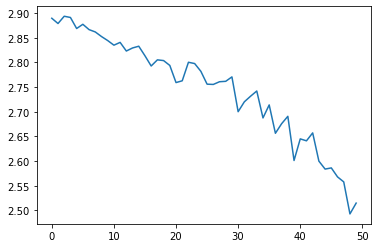

In [23]:
plt.plot(all_losses)

In [13]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.80) Japanese
(-2.80) Scottish
(-2.83) Greek

> Jackson
(-2.79) Spanish
(-2.79) Irish
(-2.81) Scottish

> Satoshi
(-2.80) Spanish
(-2.84) Japanese
(-2.84) Scottish


In [31]:
predict('Hao')
predict('Jeff')


> Hao
(-2.00) Chinese
(-2.11) Korean
(-2.29) Vietnamese

> Jeff
(-2.30) Korean
(-2.38) Chinese
(-2.60) Arabic


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [10]:
import torch.nn as nn

class RNN_New(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_New, self).__init__()

        self.hidden_size = hidden_size

        #把hidden的一部分去掉，输入128，输出64
        self.h_input = nn.Linear(hidden_size, int(hidden_size/2))

        #i2h:输入57+64，输出128
        self.i2h = nn.Linear(input_size + int(hidden_size/2), hidden_size)
        #i2h:输入57+64，输出57
        self.i2o = nn.Linear(input_size + int(hidden_size/2), input_size)
        
        #把output的一部分去掉，输入64，输出18
        self.o_output = nn.Linear(input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)#按照纬度2，按照行softmax

    def forward(self, input, hidden):
        #按维数1（列）拼接
        hidden_input = self.h_input(hidden)

        #57 + 64
        combined = torch.cat((input, hidden_input), 1)

        #128
        hidden = self.i2h(combined)

        #57
        output = self.i2o(combined)
        
        #18
        output = self.o_output(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [11]:
#init RNN_New
#n_letters = 57
#n_hidden = 128
#n_categories = 18
rnn_new = RNN_New(n_letters, n_hidden, n_categories)

In [12]:
#测试
input = line_to_tensor('Albert')
print(input.size())
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn_new(input[0], hidden)
print(output)
print(output.size())

torch.Size([6, 1, 57])
tensor([[-3.0640, -3.0092, -2.9695, -2.8426, -2.7471, -2.9847, -2.8206, -2.9802,
         -2.9474, -2.7544, -2.9878, -2.8539, -2.8813, -2.8042, -2.8400, -2.9557,
         -2.7688, -2.8937]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 18])


In [20]:
input[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [13]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

#新的学习方法，可以使用传入的RNN对象
def train_fix(category_tensor, line_tensor, rnn_model, loss_method = nn.CrossEntropyLoss()):
    if isinstance(rnn_model,RNN_New):
        hidden = rnn_model.initHidden()
    else:
        hidden = rnn_model.initHidden(line_tensor.size(1))

    #每次迭代后梯度清零
    rnn_model.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        inputfix = line_tensor[i]
        if isinstance(rnn_model,RNN_New) == False:
            inputfix = inputfix.reshape(-1,1,n_letters)
        output, hidden = rnn_model(inputfix, hidden)

    loss = loss_method(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_model.parameters():
        if p.grad is not None:
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [23]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#可移动态传入自己的rnn和loss,为后续作业提供接口，避免重复代码
def MyTraning(rnn_model = rnn_new,n_iters = 5000,print_every = 500,plot_every = 100,loss_method = nn.CrossEntropyLoss()):
    
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning()
        output, loss = train_fix(category_tensor, line_tensor,rnn_model,loss_method)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    return all_losses

In [81]:
rnn_new_lost = MyTraning(rnn_model = rnn_new, n_iters=10000)

500 5% (0m 2s) 2.8577 Close / Japanese ✗ (Greek)
1000 10% (0m 4s) 3.1088 Trujillo / German ✗ (Spanish)
1500 15% (0m 6s) 2.8698 Morjin / Scottish ✗ (Russian)
2000 20% (0m 8s) 2.7379 Miller / German ✗ (Scottish)
2500 25% (0m 10s) 2.8625 Close / Scottish ✗ (Greek)
3000 30% (0m 12s) 2.8217 Sutherland / Irish ✗ (Scottish)
3500 35% (0m 14s) 2.9128 Ha / Japanese ✗ (Korean)
4000 40% (0m 17s) 2.8261 Bao / Italian ✗ (Chinese)
4500 45% (0m 20s) 2.7982 Brousil / Russian ✗ (Czech)
5000 50% (0m 22s) 2.8803 Sun / Scottish ✗ (Korean)
5500 55% (0m 24s) 2.2168 Tokuoka / Japanese ✓
6000 60% (0m 26s) 2.5754 Roijakkers / Greek ✗ (Dutch)
6500 65% (0m 28s) 2.7270 Asfour / German ✗ (Arabic)
7000 70% (0m 31s) 2.8734 Vipond / Vietnamese ✗ (French)
7500 75% (0m 33s) 2.8385 Hout / German ✗ (Dutch)
8000 80% (0m 35s) 2.4152 Mikolajczak / Polish ✓
8500 85% (0m 37s) 2.7248 Crawford / Russian ✗ (Scottish)
9000 90% (0m 39s) 2.8379 Tighearnach / Russian ✗ (Irish)
9500 95% (0m 41s) 0.4384 Gomatos / Greek ✓
10000 100% (0m

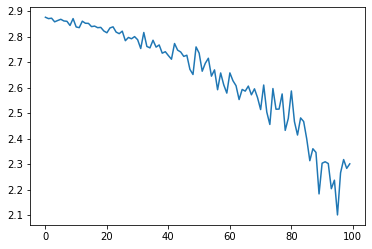

In [82]:
plt.plot(rnn_new_lost)

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

In [14]:
#定义LSTM
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,#层数
            batch_first=True,
        )
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)#按照纬度2，按照行softmax
        
    def forward(self, input, hidden):

        #(lenth,1,128)
        output,hidden = self.lstm(input,hidden)

        #(lenth,18)
        output = self.output(output[:,-1,:])

        #(lenth,18)
        output = self.softmax(output)

        return output,hidden

    def initHidden(self,batch_size):
        return (torch.rand(1,batch_size,self.hidden_size),torch.rand(1,batch_size,self.hidden_size))

In [15]:
#n_letters = 57
#n_hidden = 128
#n_categories = 18
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)

In [16]:
#测试LSTM
input = line_to_tensor('Albert')
hidden = rnn_lstm.initHidden(batch_size= input.size(1))
output, next_hidden = rnn_lstm(input[0].reshape(-1,1,57),hidden)
print(output)
print(output.size())

tensor([[-2.9205, -2.9208, -2.8870, -2.9537, -3.0535, -2.9191, -2.8809, -2.6441,
         -3.0190, -2.8066, -2.8192, -2.9265, -2.9201, -3.0013, -2.8304, -2.8163,
         -2.8332, -2.9529]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 18])


In [79]:
#训练LSTM
rnn_lstm_lost = MyTraning(rnn_model = rnn_lstm, n_iters=50000)

500 1% (0m 7s) 2.8202 Belo / Arabic ✗ (Portuguese)
1000 2% (0m 14s) 2.8415 Siena / Arabic ✗ (Italian)
1500 3% (0m 20s) 2.9247 Philips / Italian ✗ (Dutch)
2000 4% (0m 27s) 2.7495 Africani / Italian ✓
2500 5% (0m 34s) 2.8762 Shang / Scottish ✗ (Chinese)
3000 6% (0m 41s) 2.7871 Johnston / German ✗ (Scottish)
3500 7% (0m 48s) 2.8845 Samaha / Spanish ✗ (Arabic)
4000 8% (0m 56s) 2.8623 Gouveia / Spanish ✗ (Portuguese)
4500 9% (1m 3s) 2.8210 Valenti / Spanish ✗ (Italian)
5000 10% (1m 10s) 2.7643 Stamatas / Polish ✗ (Greek)
5500 11% (1m 17s) 2.9264 Paget / Arabic ✗ (French)
6000 12% (1m 23s) 2.8510 Mcdonald / German ✗ (Scottish)
6500 13% (1m 30s) 2.4874 Katsourinis / Greek ✓
7000 14% (1m 38s) 2.8345 Mulder / German ✗ (Dutch)
7500 15% (1m 45s) 1.5729 Lam / Vietnamese ✓
8000 16% (1m 52s) 2.9059 Albert / Czech ✗ (French)
8500 17% (1m 59s) 1.9545 Jing / Korean ✗ (Chinese)
9000 18% (2m 7s) 2.6156 Luong / Arabic ✗ (Vietnamese)
9500 19% (2m 14s) 2.5789 Abboud / Arabic ✓
10000 20% (2m 21s) 1.8857 Phan

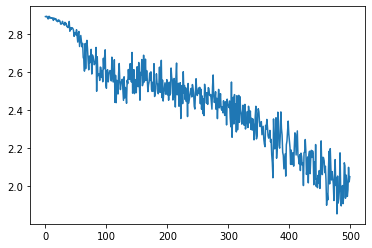

In [80]:
plt.plot(rnn_lstm_lost)

In [20]:
#定义GRU
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,#层数
            batch_first=True,
        )
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)#按照纬度2，按照行softmax
        self.fc = nn.Sequential(nn.Linear(hidden_size,output_size),
                                nn.Softmax(dim=1))
        
    def forward(self, input, hidden):

        #(lenth,1,128)
        output,hidden = self.gru(input,hidden)

        #(lenth,18)
        output = self.output(output[:,-1,:])

        #(lenth,18)
        output = self.softmax(output)
     
        #(1,18)
        #output = torch.mean(output,dim=0)
        #print(output.size())
        return output,hidden

    def initHidden(self,batch_size):
        return torch.rand(1,batch_size,self.hidden_size)

In [18]:
#n_letters = 57
#n_hidden = 128
#n_categories = 18
rnn_gru = RNN_GRU(n_letters, n_hidden, n_categories)

In [21]:
#测试GRU
input = line_to_tensor('Albert')
hidden = rnn_gru.initHidden(batch_size= input.size(1))
output, next_hidden = rnn_gru(input[0].reshape(-1,1,57),hidden)
print(output)
print(output.size())

tensor([[-2.9266, -2.9393, -2.8393, -2.6346, -3.0213, -2.9314, -2.9343, -2.7833,
         -2.8816, -3.3302, -3.2020, -3.0347, -3.0667, -2.9026, -2.8635, -2.8380,
         -2.6532, -2.5491]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 18])


In [24]:
#训练GRU
rnn_gru_lost = MyTraning(rnn_model = rnn_gru, n_iters=50000)

500 1% (0m 4s) 2.9345 Airaldi / Chinese ✗ (Italian)
1000 2% (0m 9s) 2.9189 Taverna / Chinese ✗ (Italian)
1500 3% (0m 14s) 2.7585 Paraskevopoulos / Portuguese ✗ (Greek)
2000 4% (0m 19s) 2.8713 Russell / Dutch ✗ (Scottish)
2500 5% (0m 24s) 2.9932 Assaf / Dutch ✗ (Arabic)
3000 6% (0m 28s) 2.9148 Hailov / Portuguese ✗ (Russian)
3500 7% (0m 33s) 3.0346 Drury / Chinese ✗ (English)
4000 8% (0m 38s) 2.6794 Adamczyk / Greek ✗ (Polish)
4500 9% (0m 44s) 2.8022 Descoteaux / Greek ✗ (French)
5000 10% (0m 49s) 2.9093 Qureshi / Greek ✗ (Arabic)
5500 11% (0m 54s) 2.6936 Soares / Greek ✗ (Portuguese)
6000 12% (0m 59s) 1.7568 Song / Chinese ✗ (Korean)
6500 13% (1m 4s) 2.6917 Cernohous / Greek ✗ (Czech)
7000 14% (1m 11s) 2.8079 Murtas / Arabic ✗ (Italian)
7500 15% (1m 17s) 2.9912 Denend / Arabic ✗ (Dutch)
8000 16% (1m 22s) 3.2456 Soho / Korean ✗ (Japanese)
8500 17% (1m 27s) 2.6099 Huber / Arabic ✗ (German)
9000 18% (1m 32s) 2.8911 De sauveterre / Greek ✗ (French)
9500 19% (1m 37s) 2.5047 Said / Chinese ✗

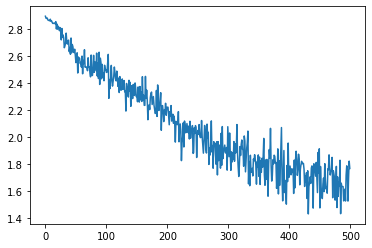

In [25]:
plt.plot(rnn_gru_lost)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> todo

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo